In [1]:
# REFERENCES: I used Chat GPT and DeepSeek to edit some of the comments (make them short and neat)
              # Also used this website: https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy?utm_source=chatgpt.com
              # for the "layers", "fit" parts of the code

In [2]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [3]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [4]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


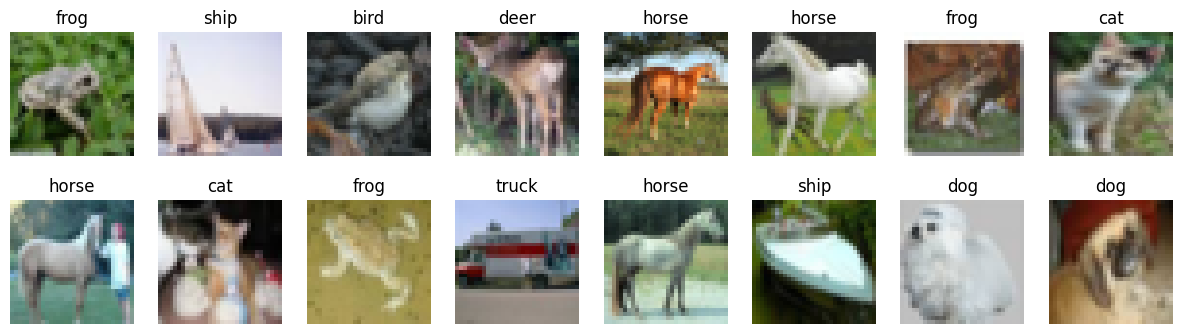

In [5]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [6]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [20]:
# import necessary building blocks (I have added some libraries here)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, LeakyReLU
from keras.datasets import cifar10
from keras import datasets, layers, models, regularizers

In [21]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
    ### Then, add a Pooling layer to pick up the relevant kernels.
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))  # Conv layer with 32 filters
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))  # Second Conv layer
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  # Downsample feature maps
    model.add(layers.Dropout(0.3))  # Drop 30% of units to prevent overfitting

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))  # Conv layer with 64 filters
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))  # Second Conv layer
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  # Downsample feature maps
    model.add(layers.Dropout(0.5))  # Drop 50% of units to prevent overfitting

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))  # Conv layer with 128 filters
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))  # Second Conv layer
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  # Downsample feature maps
    model.add(layers.Dropout(0.5))  # Drop 50% of units to prevent overfitting

    # Fully Connected Layers
    model.add(layers.Flatten())  # Flatten 3D feature maps to 1D
    model.add(layers.Dense(128, activation='relu'))  # Fully connected layer with 128 units
    model.add(layers.BatchNormalization())  # Normalize activations
    model.add(layers.Dropout(0.5))  # Drop 50% of units to prevent overfitting

    # Output Layer
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))  # Output layer with softmax for classification
        ### END STUDENT CODE ###


    return model

In [22]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 30


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)


# fit model
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_val, y_val))

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3192 - loss: 2.0276 - val_accuracy: 0.4753 - val_loss: 1.4812
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5333 - loss: 1.3025 - val_accuracy: 0.6349 - val_loss: 1.0329
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6276 - loss: 1.0592 - val_accuracy: 0.6454 - val_loss: 1.0229
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.6689 - loss: 0.9503 - val_accuracy: 0.7346 - val_loss: 0.7550
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6978 - loss: 0.8642 - val_accuracy: 0.6559 - val_loss: 0.9819
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7225 - loss: 0.8058 - val_accuracy: 0.7061 - val_loss: 0.8421
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7362 - loss: 0.7586 - val_accuracy: 0.7370 - val_loss: 0.7539
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7579 - loss: 0.7072

In [23]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


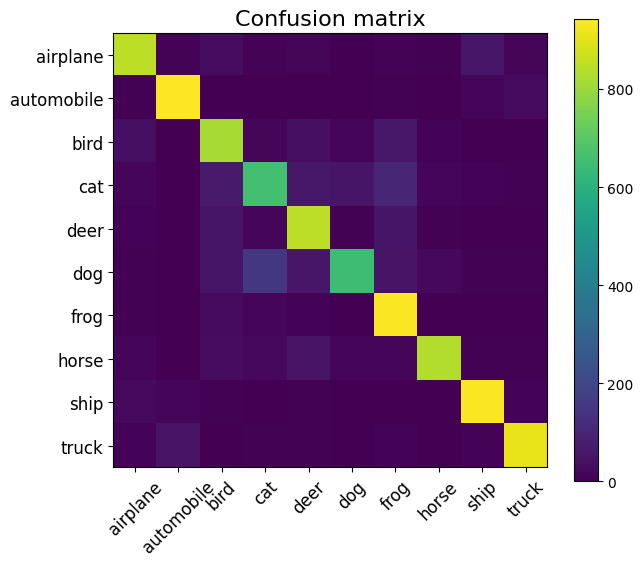

Test accuracy: 0.8389


In [24]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

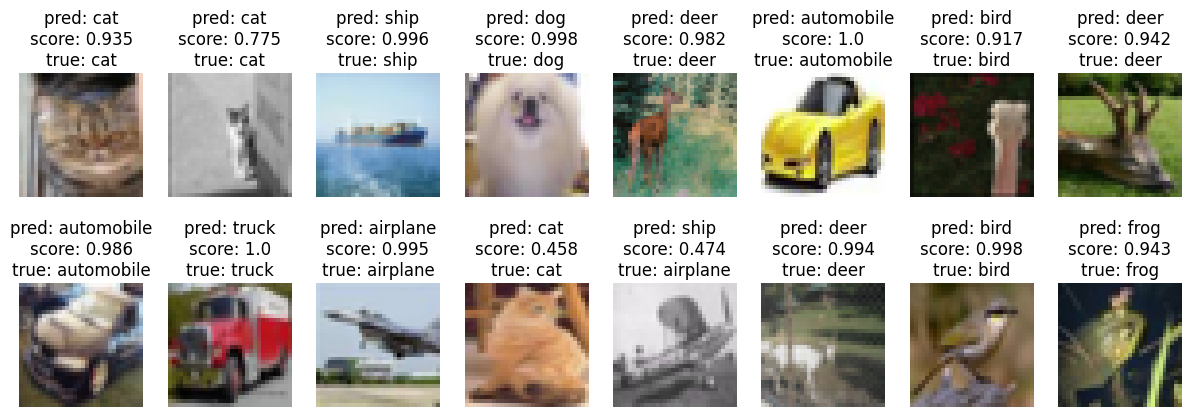

In [25]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




In [ ]:
# I started by defining a CNN model using keras

#FIRST CODES (v. 1.0)
    # Initially, I began by creating a "basic CNN code". Very similar to the ones we used during the skill class (part of it can be seen below):

    #    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    #     model.add(Activation('relu'))
    #     model.add(MaxPooling2D(pool_size=(2, 2)))

    # It had 3 convolutional blocks, each consisting of a Conv2D layer, a ReLU activation, and a max-pooling layer.
    # After flattening the output, I added a fully connected (dense) layer with dropout for regularization and
    # an output layer with softmax activation for classification.
    # I played with the Epochs and Batch sizes and got ~0.7 accuracy (using 100 Epochs and 64 batch sizes and given learning rate)
    # (probably an overkill).

#SECOND CODE (v. 2.0) (this one)
    # My second code was a modified version of the first one. I have added batch normalization after almost every layer to stabilize training
    # and improve convergence and dropout more frequently to prevent overfitting.
    # I used double convolutional layers along with the former and ReLU activation (as well as max-pooling and dropout)
    # As a result, I got ~0.85 accuracy (first using 100 Epochs and 64 batch sizes and given learning rate, then using 30 epochs, 32 batch)